In [16]:
#import relevant packages
import pandas as pd
import numpy as np
import json
from sklearn.cluster import AgglomerativeClustering
import spacy
import hdbscan
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#read in data
data_raw = pd.DataFrame(json.load(open("ecfs_17-108_0.json")))

In [4]:
%%time
#drop rows with NaN in the comments
rows_to_drop = list()
for ii in range(3,len(data_raw["text_data"])):
    if pd.isnull(data_raw["text_data"][ii]) == True:
        if pd.isnull(data_raw["text_data_docs"][ii][0]) == True:
            rows_to_drop.append(ii)
            
data = data_raw.drop(rows_to_drop)

CPU times: user 323 ms, sys: 15.4 ms, total: 339 ms
Wall time: 342 ms


In [5]:
#get text of comments
text_list = list()
for ii in range(3,len(data["text_data"])):
        if pd.isnull(data["text_data"][ii]) == False:
            text_list.append(data["text_data"][ii])
        elif pd.isnull(data["text_data_docs"][ii][0]) == False:
            if type(data["text_data_docs"][ii][0]) == dict:
                text_list.append(data["text_data_docs"][ii][0]["data"])
            else:
                text_list.append(data["text_data_docs"][ii][0])
        else:
            continue

In [6]:
%%time
#vectorize text
nlp = spacy.load("en")

text_vec = list()

for comm in text_list:
    if type(comm) == str:
        comm_broken_down = nlp(comm)
        comm_vec = np.mean([word.vector for word in comm_broken_down], axis=0)
        text_vec.append(comm_vec)
    else:
        text_vec.append(np.zeros(len(comm_vec)))        

CPU times: user 45min 57s, sys: 48.9 s, total: 46min 46s
Wall time: 24min


In [8]:
%%time
#check silhouette scores with AgglomerativeClustering
sil_avg = list()

text = pd.DataFrame()
conf_num = data["confirmation_number"][3:].tolist()
text["confirmation_number"] = conf_num
text["text_data"] = text_list

num_clusters = [30,40,50,60,70,80,90,100]
for num in num_clusters:
    clusterer = AgglomerativeClustering(n_clusters=num, linkage='ward')
    labels = clusterer.fit_predict(text_vec)
    text["cluster_id"] = labels
    text = pd.concat([text["cluster_id"],text["confirmation_number"],
                  text["text_data"],pd.DataFrame(text_vec)],axis=1)
    #get average silhouette score to determine whether number of clusters was appropriate
    features = text.iloc[:,-384:]
    silhouette_avg = silhouette_score(features,labels)
    sil_avg.append(silhouette_avg)

CPU times: user 7min 46s, sys: 24.6 s, total: 8min 10s
Wall time: 7min 49s


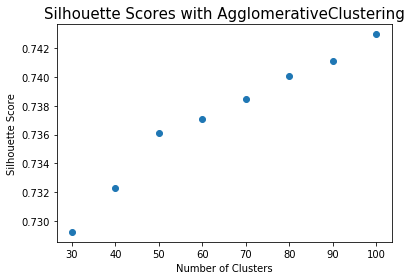

In [15]:
plt.plot(num_clusters,sil_avg,'o')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores with AgglomerativeClustering",fontsize=15);

In [26]:
%%time
#check silhouette scores with HDBSCAN
sil_avg2 = list()

text = pd.DataFrame()
conf_num = data["confirmation_number"][3:].tolist()
text["confirmation_number"] = conf_num
text["text_data"] = text_list

num2 = [5,10,15,20,25,30,35,40]

for num in num2:
    clusterer2 = hdbscan.HDBSCAN(min_cluster_size=num)
    clustered_text = clusterer2.fit_predict(text_vec)
    labels2 = clusterer2.labels_
    text["cluster_id"] = labels2
    text = pd.concat([text["cluster_id"],text["confirmation_number"],
                  text["text_data"],pd.DataFrame(text_vec)],axis=1)
    #get average silhouette score to determine whether number of clusters was appropriate
    features = text.iloc[:,-384:]
    silhouette_avg = silhouette_score(features,labels2)
    sil_avg2.append(silhouette_avg)

CPU times: user 14min 42s, sys: 23.5 s, total: 15min 6s
Wall time: 14min 40s


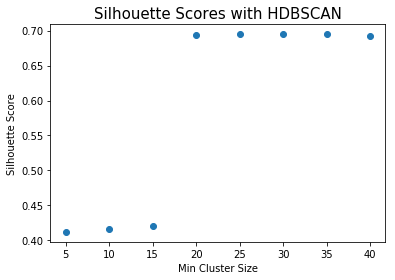

In [28]:
plt.plot(num2,sil_avg2,'o')
plt.xlabel("Min Cluster Size")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores with HDBSCAN",fontsize=15);

In [35]:
%%time
num=50
#cluster text vectors and generate silhouette scores
clusterer = AgglomerativeClustering(n_clusters=num, linkage='ward')
labels = clusterer.fit_predict(text_vec)

text = pd.DataFrame()
conf_num = data["confirmation_number"][3:].tolist()
text["confirmation_number"] = conf_num
text["text_data"] = text_list
text["cluster_id"] = labels
text = pd.concat([text["cluster_id"],text["confirmation_number"],
                  text["text_data"],pd.DataFrame(text_vec)],axis=1)

CPU times: user 1min 2s, sys: 2.56 s, total: 1min 4s
Wall time: 1min 5s


The silhouette score plots suggest that AgglomerativeClustering might be better for our data. The silhouette score isn't greatly impacted by the number of clusters chosen after num = 50. Similar comments could be broken down into many clusters so it isn't advantageous to choose too many clusters while trying to identify the context of comments.

In [36]:
#write the results to an output file
text.to_csv("fcc_comments_clustered.csv")